In [1]:
import pystan
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import arviz as az
from scipy.stats import norm, t
%matplotlib inline
plt.style.use('seaborn-white')

In [2]:
df = pd.read_csv('data/RatLives.csv', dtype={'Group':'category'})

In [3]:
data = {
    'Ntotal': df.Group.size,
    'x': df.Group.cat.codes + 1,
    'y': df.DaysLive,
    'meanY': df.DaysLive.mean(),
    'sdY': df.DaysLive.std()
}

In [4]:
model = pystan.StanModel(file='./models/ratlives.stan')
fit = model.sampling(data=data, iter=5000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_76cac5f485ca417b0c428bc70f63fb35 NOW.


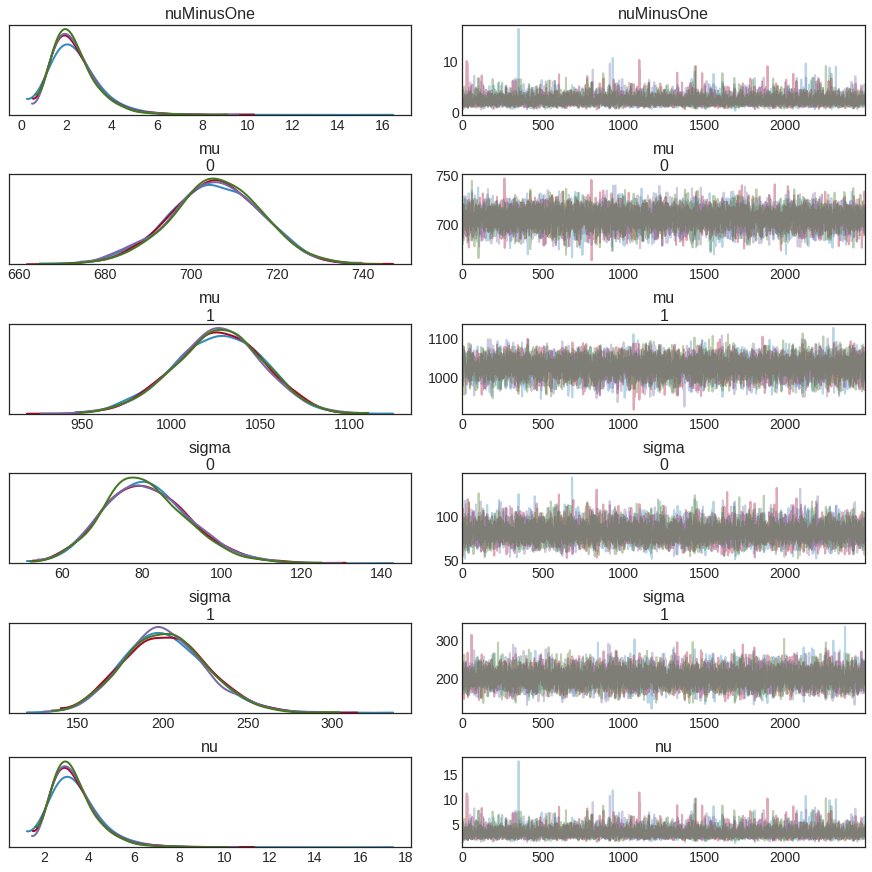

In [5]:
az.plot_trace(fit);

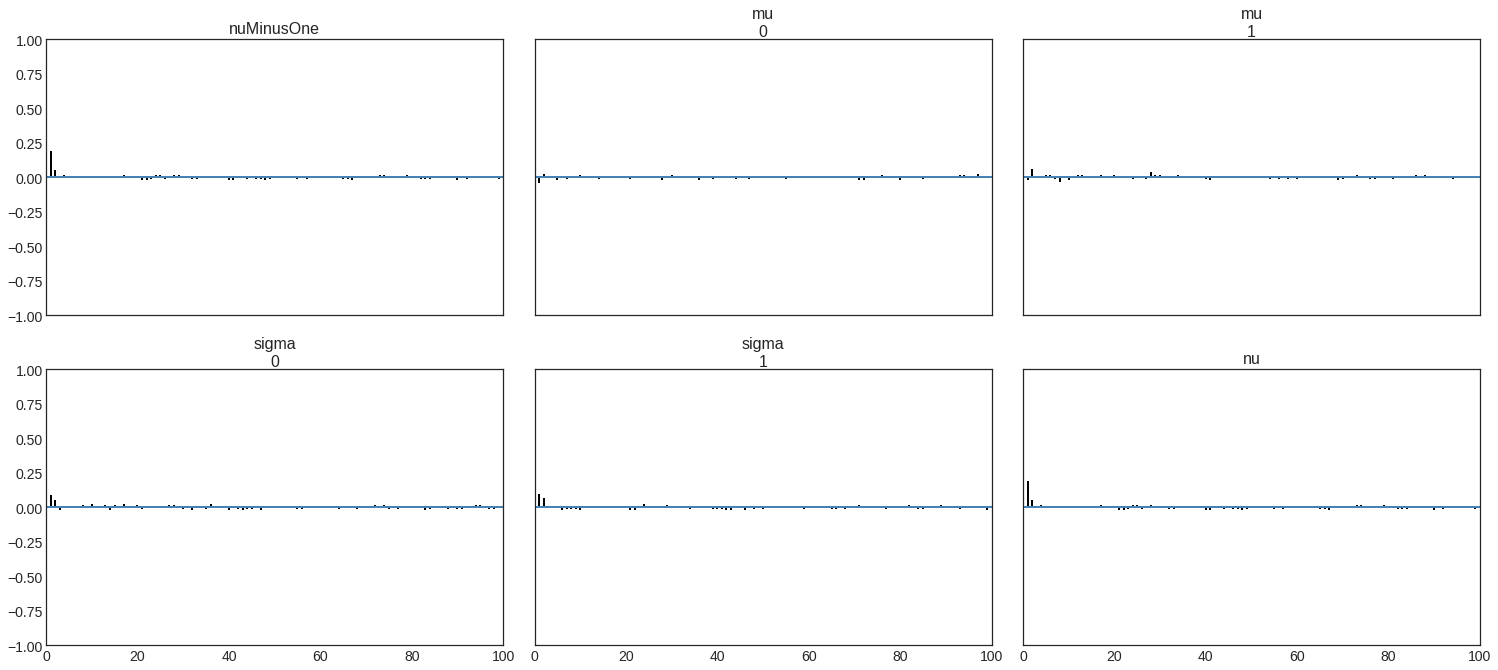

In [6]:
az.plot_autocorr(fit, combined=True);

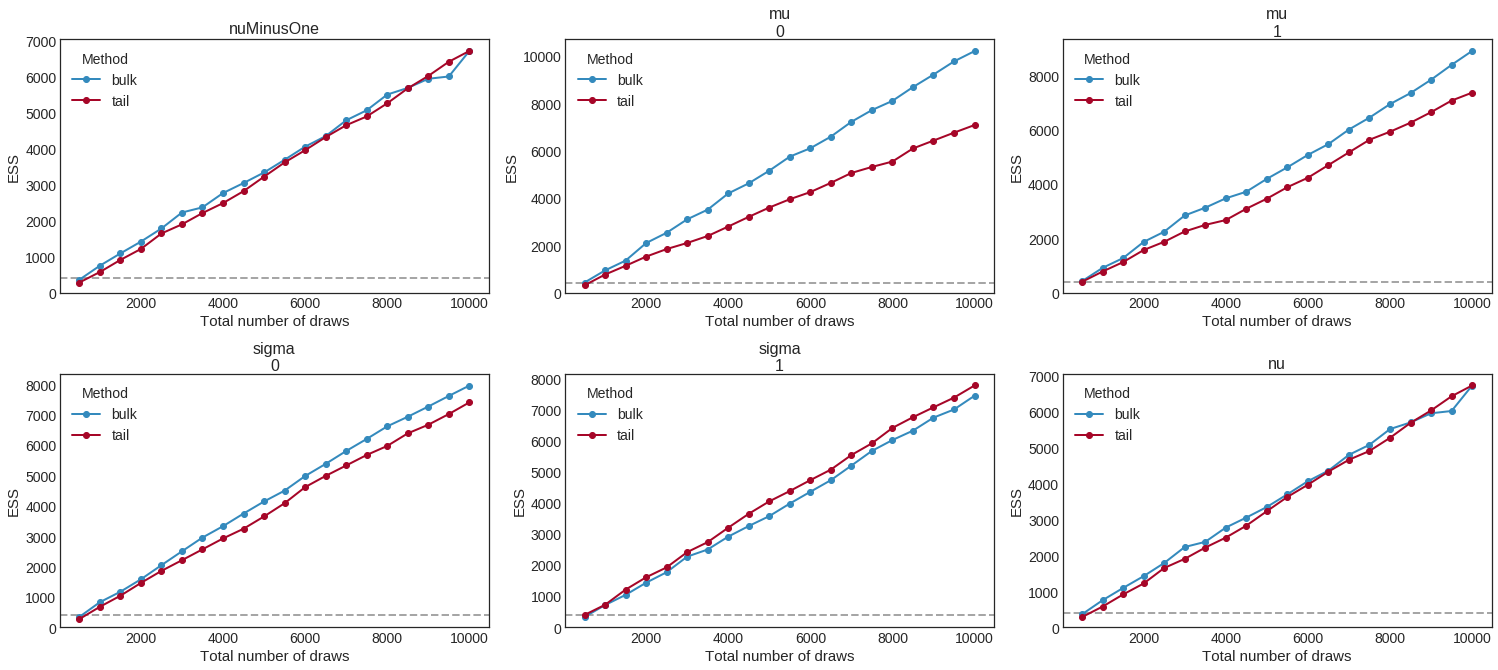

In [7]:
az.plot_ess(fit, kind="evolution");

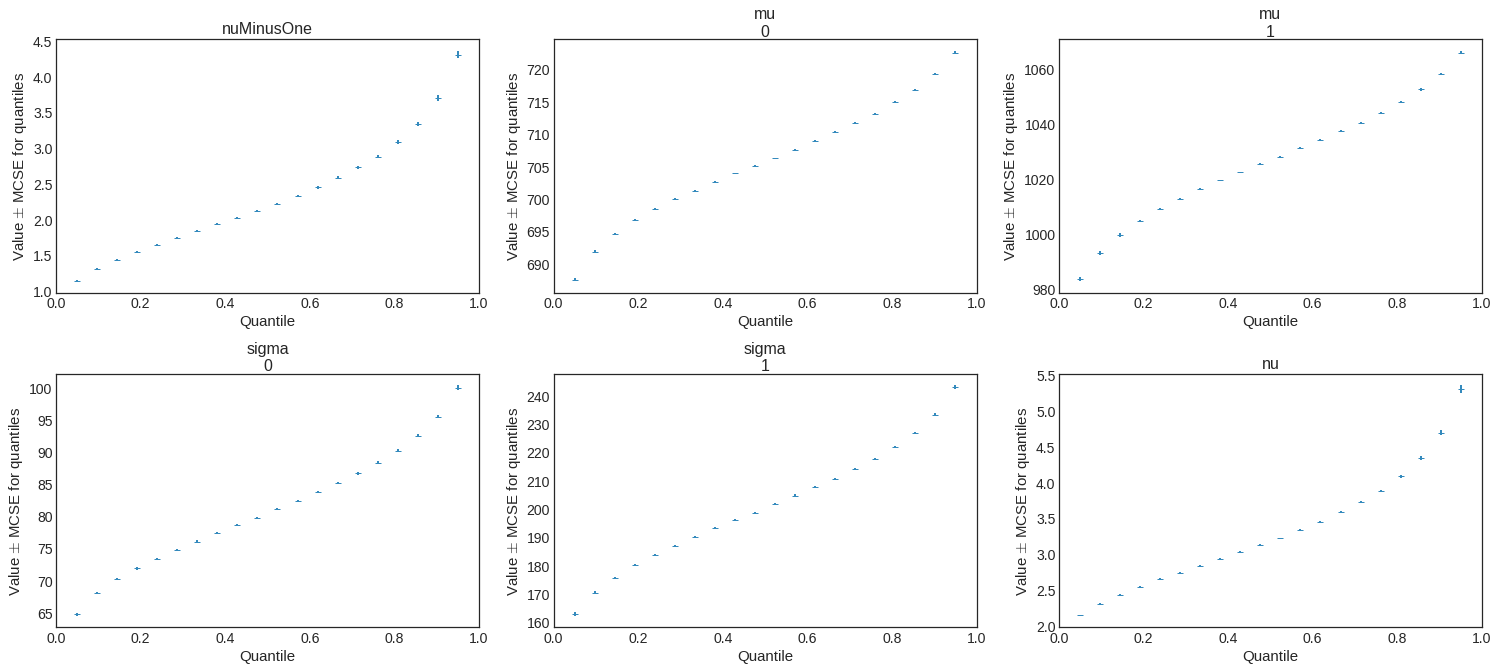

In [8]:
az.plot_mcse(fit, errorbar=True);

In [9]:
fit_df = fit.to_dataframe()

In [10]:
fit_df.head()

,chain,draw,warmup,nuMinusOne,mu[1],mu[2],sigma[1],sigma[2],nu,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__
0,0,0,0,1.756156,706.095681,1010.787602,77.477228,170.044531,2.756156,-1171.720406,0.993905,0.487588,3,7,0,1174.424631
1,0,1,0,1.566692,724.072347,1034.798394,73.179513,199.753843,2.566692,-1172.304477,0.987550,0.487588,3,7,0,1173.329882
2,0,2,0,2.316069,678.394476,994.291110,82.556915,201.793625,3.316069,-1174.520551,0.850461,0.487588,3,7,0,1177.779300
3,0,3,0,2.206704,704.091978,1027.665944,83.999522,235.238954,3.206704,-1171.922110,0.874084,0.487588,3,7,0,1176.767192
4,0,4,0,2.489000,702.671506,1026.783334,81.652176,203.038584,3.489000,-1170.357654,0.963213,0.487588,2,3,0,1172.494059


In [11]:
def post_pred_plot(ax, title, df, trace, font_d={'size':16}, colors={'color_1': 'steelblue', 'color_2': '#87ceeb'}, n_curves=20, bins=25, x_range=None):
    # Configure chart
    [ ax.spines[spine].set_visible(False) for spine in ['left', 'right', 'top'] ]
    ax.yaxis.set_visible(False)    
    ax.set_title(title, font_d)
    ax.set_xlabel('y', font_d)
    
    # Draw hist
    ax.hist(df, bins=bins, density=True, color=colors['color_1'], range=x_range)
    
    # Draw post-pred curve
    trace_len = trace.shape[0]
    idx = np.arange(0, trace_len, trace_len//n_curves)
    

    x_range_min = df.min()
    x_range_max = df.max()
    
    if x_range is not None:
        x_range_min = x_range[0]
        x_range_max = x_range[1]
        
    curve_x_range = np.arange(x_range_min, x_range_max)
    x = np.tile(curve_x_range.reshape(-1, 1), (1, n_curves))
    ax.plot(x, t.pdf(x, loc=trace['mu'][idx], scale=trace['sigma'][idx], df=trace['nu'][idx]), c=colors['color_2'])

In [12]:
def plot_var_dist(ax, title, xlabel, var, font_d={'size':16}, color='#87ceeb', rope=None, round_to=5, ref_val=0, credible_interval=0.95, x_range=None):
    if rope is None:
        az.plot_posterior(var, point_estimate='mode', round_to=round_to, ax=ax, color=color, kind='hist', credible_interval=credible_interval, range=x_range)
    else:
        az.plot_posterior(var, point_estimate='mode', round_to=round_to, ref_val=ref_val, rope=rope, ax=ax, color=color, kind='hist', credible_interval=credible_interval, range=x_range)
        
    ax.set_xlabel(xlabel, font_d)
    ax.set_title(title, font_d)

In [13]:
def plot_two_group_summary(df, fit_df, param_rope, effect_rope, font_d={'size':16}, color='#87ceeb'):
    
    fit_df['log_nu'] = np.log10(fit_df['nu'])
    
    fig, axes = plt.subplots(5,2, figsize=(12, 12))
    
    # Left Column Figures
    mean_xrange = (fit_df[['mu[1]', 'mu[2]']].min(axis=1).min(), fit_df[['mu[1]', 'mu[2]']].max(axis=1).max())
    plot_var_dist(axes[0,0], "%s Mean" % df.Group.cat.categories[0], '$\mu_0$', fit_df['mu[1]'].values, x_range=mean_xrange)
    plot_var_dist(axes[1,0], "%s Mean" % df.Group.cat.categories[1], '$\mu_1$', fit_df['mu[2]'].values, x_range=mean_xrange)
    
    sigma_xrange = (fit_df[['sigma[1]', 'sigma[2]']].min(axis=1).min(), fit_df[['sigma[1]', 'sigma[2]']].max(axis=1).max())
    plot_var_dist(axes[2,0], "%s Scale" % df.Group.cat.categories[0], '$\sigma_0$', fit_df['sigma[1]'].values, x_range=sigma_xrange)
    plot_var_dist(axes[3,0], "%s Scale" % df.Group.cat.categories[1], '$\sigma_1$', fit_df['sigma[2]'].values, x_range=sigma_xrange)
    
    plot_var_dist(axes[4,0], 'Normality', r'log10($\nu$)', fit_df['log_nu'].values)
    
    # Right Column Figures
    
    # -> Post-Pred figs
    x_range = (df.Y.min(), df.Y.max())
    
    group0_title = "Data for %s w. Post. Pred." % df.Group.cat.categories[0]
    group0_trace = fit_df[['mu[1]', 'sigma[1]', 'nu']].copy().rename(columns={"mu[1]": "mu", "sigma[1]": "sigma"})
    group0_df = df.Y[df.Group == df.Group.cat.categories[0]]
    post_pred_plot(axes[0,1], group0_title, group0_df, group0_trace, x_range=x_range)
    
    group1_title = "Data for %s w. Post. Pred." % df.Group.cat.categories[1]
    group1_trace = fit_df[['mu[2]', 'sigma[2]', 'nu']].copy().rename(columns={"mu[2]": "mu", "sigma[2]": "sigma"})
    group1_df = df.Y[df.Group == df.Group.cat.categories[1]]
    post_pred_plot(axes[1,1], group1_title, group1_df, group1_trace, x_range=x_range)
    
    # Figs 3-5
    plot_var_dist(axes[2,1], 'Difference of Means', '$\mu_1 - \mu_0$', (fit_df['mu[2]'] - fit_df['mu[1]']).values, rope=param_rope)
    plot_var_dist(axes[3,1], 'Difference of Scales', '$\sigma_1 - \sigma_0$', (fit_df['sigma[2]'] - fit_df['sigma[1]']).values, rope=param_rope)
    plot_var_dist(axes[4,1], 'Effect Size', r'$\frac{(\mu_1-\mu_0)}{\sqrt{(\sigma_0^2+\sigma_1^2)/2}}$', ((fit_df['mu[2]'] - fit_df['mu[1]'])/np.sqrt((fit_df['sigma[1]']**2+fit_df['sigma[2]']**2)/2)).values, rope=effect_rope)
    
    return fig, axes

# Exercise 16.2(a)

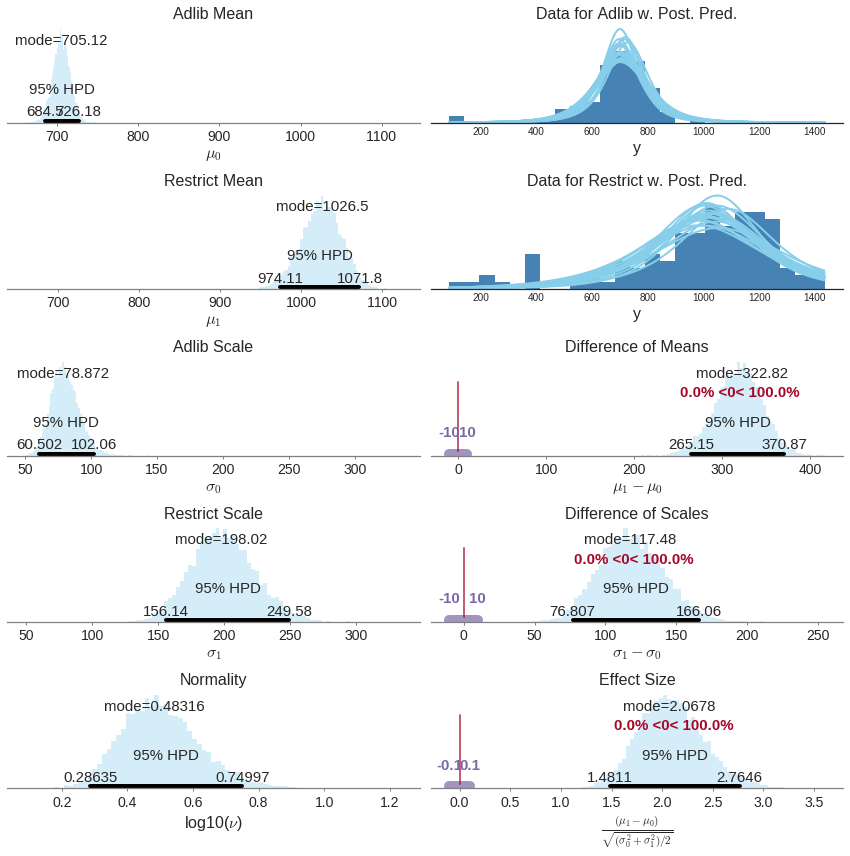

In [14]:
df = df.rename(columns={'DaysLive': 'Y'})
fig, ax = plot_two_group_summary(df, fit_df, param_rope=(-10, 10), effect_rope=(-0.1, 0.1))
plt.tight_layout();

# Exercise 16.2(b)

In [19]:
df2 = df.copy()
df2['DaysLive^2'] = df2.Y ** 2

In [20]:
data2 = {
    'Ntotal': df2.Group.size,
    'x': df2.Group.cat.codes + 1,
    'y': df2['DaysLive^2'],
    'meanY': df2['DaysLive^2'].mean(),
    'sdY': df2['DaysLive^2'].std()
}

In [32]:
df2.describe()

,Y,DaysLive^2
count,195.000000,1.950000e+02
mean,838.789744,7.754037e+05
std,268.711189,4.485735e+05
min,89.000000,7.921000e+03
25%,679.500000,4.617225e+05
50%,791.000000,6.256810e+05
75%,1052.000000,1.106729e+06
max,1435.000000,2.059225e+06


In [36]:
data2['x']

0      1
1      1
2      1
3      1
4      1
      ..
190    2
191    2
192    2
193    2
194    2
Length: 195, dtype: int8

In [37]:
data2['y']

0         7921
1        10816
2       149769
3       216225
4       229441
        ...   
190    1760929
191    1763584
192    1874161
193    1940449
194    2059225
Name: DaysLive^2, Length: 195, dtype: int64

In [ ]:
"""
As it stands, I have difficulty getting STAN to work with the DaysLive^2 model.

The error I receive from stan in the console is to the effect of:

"
Rejecting initial value:
Initialization between (-2, 2) failed after 100 attempts. 
  Log probability evaluates to log(0), i.e. negative infinity.
 Try specifying initial values, reducing ranges of constrained values, or reparameterizing the model.
  Stan can't start sampling from this initial value.

Initialization between (-2, 2) failed after 100 attempts. 
 Try specifying initial values, reducing ranges of constrained values, or reparameterizing the model.
"

I have attempted parsing out the STAN model to its own model file and reducing
the overall scale of t he data for unifHi and unifLo boundaries to no effect.

I do not know where the (-2, 2) initialization is occurring

"""
#model = pystan.StanModel(file='./models/ratlives-sq.stan')
#fit2 = model.sampling(data=data2, iter=1000, chains=4)

In [ ]:
#az.plot_trace(fit2);

In [ ]:
#az.plot_autocorr(fit2, combined=True);

In [ ]:
#az.plot_ess(fit2, kind="evolution");

In [ ]:
#az.plot_mcse(fit2, errorbar=True);

In [ ]:
#fit_df2 = fit.to_dataframe()
#df2 = df2.rename(columns={"DaysLive^2", "Y"})

In [ ]:
#fig, ax = plot_two_group_summary(df2, fit_df2, param_rope=(-100, 100), effect_rope=(-0.1, 0.1))
#plt.tight_layout();